<a href="https://colab.research.google.com/github/mmajidawan/Test/blob/main/tbx11k_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import time
import glob
import random
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import cv2
import shutil
import lxml
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu

In [ ]:
dirlist = ['/content/drive/MyDrive/TBX11k_Dataset/TBX11K/TBX11K/imgs/health', '/content/drive/MyDrive/TBX11k_Dataset/TBX11K/TBX11K/imgs/sick', '/content/drive/MyDrive/TBX11k_Dataset/TBX11K/TBX11K/imgs/tb']
classes = ['Healthy', 'Sick', 'Tuberculosis']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  8400    labels:  8400


In [ ]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(8400,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy         3800
Sick            3800
Tuberculosis     800
Name: labels, dtype: int64


# **Balance dataset to acheive better result**



In [ ]:
file_count = 800
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (df['labels'].value_counts())
print (len(df))

Sick            800
Healthy         800
Tuberculosis    800
Name: labels, dtype: int64
2400


# **Visualize Images**

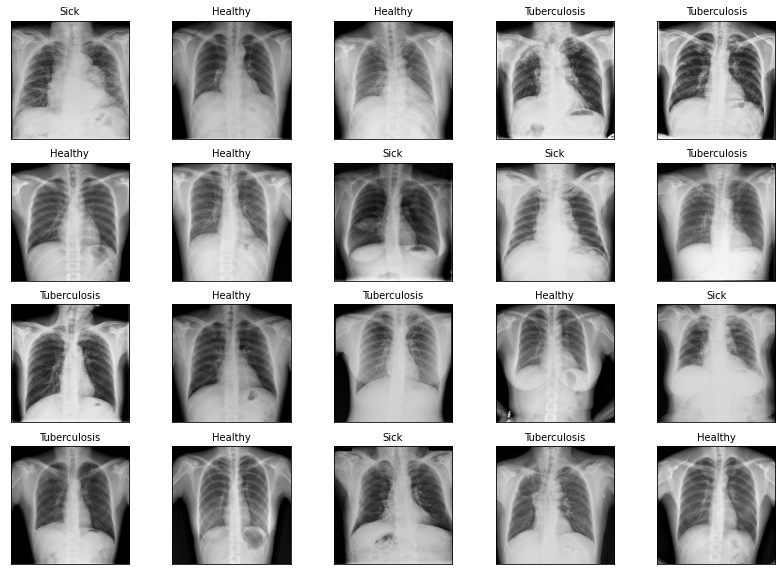

In [ ]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    img = df.loc[random,"file_paths"]
    plt.imshow(plt.imread(img))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

    
plt.show()

Looks like we can do horizontal flips with ImageDataGenerator.

# **Split Dataframe into Train, Valid, and Test**

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

Tuberculosis    685
Sick            684
Healthy         683
Name: labels, dtype: int64
Sick            79
Healthy         79
Tuberculosis    70
Name: labels, dtype: int64
Tuberculosis    45
Healthy         38
Sick            37
Name: labels, dtype: int64


# **ImageDataGenerator**

In [ ]:
target_size=(224,224)
batch_size=16

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 2052 validated image filenames belonging to 3 classes.
Found 228 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


# **ResNet-50 Model**

In [ ]:
img_height, img_width = 224,224
conv_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))


94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
#for layer in conv_base.layers:
#    layer.trainable = False

In [ ]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7f3da24a90> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7f282478d0> True
<keras.layers.convolutional.Conv2D object at 0x7f7f281dfb50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7f281dfd90> True
<keras.layers.core.activation.Activation object at 0x7f7f28232e10> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7f282327d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f7f28284b90> True
<keras.layers.convolutional.Conv2D object at 0x7f7f2829a9d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7f2833f650> True
<keras.layers.core.activation.Activation object at 0x7f7f28217690> True
<keras.layers.convolutional.Conv2D object at 0x7f7f28658410> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7f28d1fd90> True
<keras.layers.core.activation.Activation object at 0x7f7f28cd8390> True
<keras.layer

In [ ]:
classify_model = tf.keras.Sequential()
classify_model.add(conv_base)
classify_model.add(tf.keras.layers.Dense(3, activation='softmax'))
classify_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
lr=0.001
classify_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Custom Callbacks**

In [ ]:
patience = 2
stop_patience = 5
factor = 0.5

callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint("classify_model.h5", monitor='val_loss', save_best_only=True, verbose = 0),
    #tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

# **Training**

In [ ]:
epochs = 40
history = classify_model.fit(train_gen, validation_data=valid_gen, callbacks=callbacks,  epochs=epochs, verbose=1)

Epoch 1/40
129/129 [==============================] - 662s 5s/step - loss: 3.6016 - accuracy: 0.7383 - val_loss: 327142.7500 - val_accuracy: 0.3070 - lr: 0.0010
Epoch 2/40
129/129 [==============================] - 29s 226ms/step - loss: 1.0992 - accuracy: 0.8021 - val_loss: 10.3420 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/40
129/129 [==============================] - 28s 212ms/step - loss: 1.1395 - accuracy: 0.8246 - val_loss: 1444.0090 - val_accuracy: 0.3070 - lr: 0.0010
Epoch 4/40
129/129 [==============================] - ETA: 0s - loss: 2.9442 - accuracy: 0.7173
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
129/129 [==============================] - 27s 211ms/step - loss: 2.9442 - accuracy: 0.7173 - val_loss: 213965.2969 - val_accuracy: 0.3465 - lr: 0.0010
Epoch 5/40
129/129 [==============================] - 27s 210ms/step - loss: 1.4399 - accuracy: 0.6750 - val_loss: 877.1198 - val_accuracy: 0.3684 - lr: 5.0000e-04
Epoch 6/40
129/129 [===========

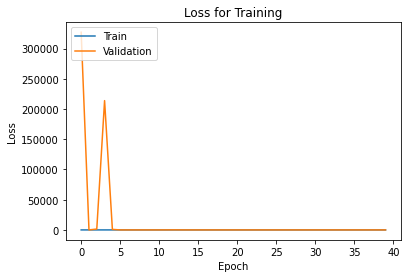

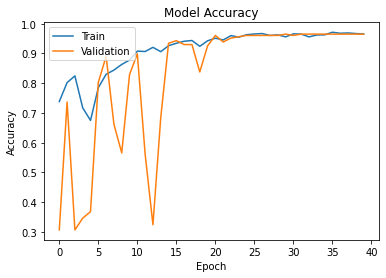

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
classify_model.evaluate(test_gen)

8/8 [==============================] - 28s 4s/step - loss: 0.0894 - accuracy: 0.9750


[0.08939863741397858, 0.9750000238418579]

Save Model in Drive

In [ ]:
filename = '/content/drive/MyDrive/TBX11k_Dataset/saved_Resnet50'
classify_model.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TBX11k_Dataset/saved_Resnet50/assets


In [ ]:
pwd

'/content'